In [1]:
import pandas, supervenn

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

In [3]:
annotation_file = '/Users/adrian/research/egilsstadir/results/deseq2/annotation.tsv'
expression_file = '/Users/adrian/research/egilsstadir/results/deseq2/DESeq2_TPM_values.tsv'

input_file_dir = '/Users/adrian/research/egilsstadir/results/deseq2/'
input_files = ['effect_WT_vs_KO.tsv', 'effect_202low_vs_KO.tsv', 'effect_202high_vs_KO.tsv', 'effect_202high_vs_202low.tsv']

output_folder = '/Users/adrian/research/egilsstadir/results/response_genes/'

# read annotation

In [4]:
anno = pandas.read_csv(annotation_file, sep='\t')
anno.set_index('ensembl_gene_id', inplace=True)
anno.drop(['ensembl_transcript_id', 'Unnamed: 0'], axis='columns', inplace=True)
anno.drop_duplicates(inplace=True)

anno['Description'] = anno['description'].str.split(' \[', expand=True)[0]
anno.drop(['description'], axis='columns', inplace=True)

anno

,external_gene_name,gene_biotype,Description
ensembl_gene_id,,,
ENSG00000210049,MT-TF,Mt_tRNA,mitochondrially encoded tRNA-Phe (UUU/C)
ENSG00000211459,MT-RNR1,Mt_rRNA,mitochondrially encoded 12S rRNA
ENSG00000210077,MT-TV,Mt_tRNA,mitochondrially encoded tRNA-Val (GUN)
ENSG00000210082,MT-RNR2,Mt_rRNA,mitochondrially encoded 16S rRNA
ENSG00000209082,MT-TL1,Mt_tRNA,mitochondrially encoded tRNA-Leu (UUA/G) 1
...,...,...,...
ENSG00000232679,LINC01705,lncRNA,long intergenic non-protein coding RNA 1705
ENSG00000200033,RNU6-403P,snRNA,"RNA, U6 small nuclear 403, pseudogene"
ENSG00000228437,LINC02474,lncRNA,long intergenic non-protein coding RNA 2474


# read and manipulate expression

In [5]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)

# 18 :: ko_high
# 42 :: ko_wt
# 63 :: ko_ko
# wt :: wt_wt

a = expression.iloc[:, 0:3]  # ko_high
b = expression.iloc[:, 3:6]  # ko_wt
c = expression.iloc[:, 6:9]  # ko_ko
d = expression.iloc[:, 9:12] # wt_wt

expression['ko_high'] = a.median(axis=1)
expression['ko_wt'] = b.median(axis=1)
expression['ko_ko'] = c.median(axis=1)
expression['wt_wt'] = d.median(axis=1)

median_expression = expression.iloc[:, 12:]
median_expression

,ko_high,ko_wt,ko_ko,wt_wt
ENSG00000000003,14.562258,20.335713,26.936171,18.328858
ENSG00000000005,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,160.564616,206.499623,224.522927,125.015988
ENSG00000000457,5.435015,8.201322,13.819072,11.559401
ENSG00000000460,9.468976,7.670167,11.758257,13.034586
...,...,...,...,...
ENSG00000293548,0.000000,0.048145,0.032292,0.062153
ENSG00000293550,0.296535,0.644327,0.247794,0.220448
ENSG00000293553,0.000000,0.000000,0.000000,0.000000
ENSG00000293563,0.000000,0.000000,0.000000,0.000000


# read DEGs and final formatting

In [6]:
input_files = ['effect_WT_vs_KO.tsv', 'effect_202low_vs_KO.tsv', 'effect_202high_vs_KO.tsv', 'effect_202high_vs_202low.tsv']
final_tables = []

In [7]:
for i in range(len(input_files)):

    # get DEGs
    working_file = input_file_dir+input_files[i]
    df = pandas.read_csv(working_file, sep='\t')
    df.drop(['baseMean', 'lfcSE', 'stat', 'pvalue'], axis=1, inplace=True)

    # get annotation
    annotated_df = df.join(anno)

    # get expression
    full_df = annotated_df.join(median_expression)

    # drop expression values we dont need
    if i == 0:
        dropping = ['ko_high', 'ko_wt']; new_names = {"ko_ko":"Reference expression [TPM]", "wt_wt":"Condition expression [TPM]"}
    if i == 1:
        dropping = ['ko_high', 'wt_wt']; new_names = {"ko_ko":"Reference expression [TPM]", "ko_wt":"Condition expression [TPM]"}
    if i == 2:
        dropping = ['ko_wt', 'wt_wt']; new_names = {"ko_ko":"Reference expression [TPM]", "ko_high":"Condition expression [TPM]"}
    if i == 3:
        dropping = ['ko_ko', 'wt_wt']; new_names = {"ko_wt":"Reference expression [TPM]", "ko_high":"Condition expression [TPM]"}
        
    
    full_df.drop(dropping, axis='columns', inplace=True)
    full_df.rename(columns=new_names, inplace=True)

    # drop DEGs whose max median expression is below 2 TPM
    condition_a = full_df[['Reference expression [TPM]', 'Condition expression [TPM]']].max(axis=1) >= 2
    condition_b = full_df[['Reference expression [TPM]', 'Condition expression [TPM]']].max(axis=1) < 2
    top = full_df[condition_a]
    noise = full_df[condition_b]
    print('starting from {} DEGs we filtered out {} because of low expression, remaining {}.'.format(full_df.shape[0], noise.shape[0], top.shape[0]))
    
    # renaming columns for convenience
    final_df = top.rename(columns={'log2FoldChange':'log2 fold-change', 'padj':'adjusted P', 'external_gene_name':'Gene name', "gene_biotype":"Gene biotype"})

    # sort
    final_df.sort_values(by='adjusted P', inplace=True)
    to_store = final_df[['Gene biotype', 'Gene name', 'Description', 'Reference expression [TPM]', 'Condition expression [TPM]', 'log2 fold-change', 'adjusted P']]

    # write a file
    output_file_name = output_folder + input_files[i].replace('.tsv', '.formatted.tsv')
    to_store.to_csv(output_file_name, sep='\t')

    output_file_name = output_folder + input_files[i].replace('.tsv', '.noise.tsv')
    noise.to_csv(output_file_name, sep='\t')

    final_tables.append(to_store)

to_store.head()

starting from 834 DEGs we filtered out 247 because of low expression, remaining 587.
starting from 1450 DEGs we filtered out 510 because of low expression, remaining 940.
starting from 1687 DEGs we filtered out 508 because of low expression, remaining 1179.
starting from 1469 DEGs we filtered out 439 because of low expression, remaining 1030.


,Gene biotype,Gene name,Description,Reference expression [TPM],Condition expression [TPM],log2 fold-change,adjusted P
ENSG00000125255,protein_coding,SLC10A2,solute carrier family 10 member 2,30.975728,0.300634,6.464333,2.098651e-205
ENSG00000272602,protein_coding,ZNF595,zinc finger protein 595,66.678656,2.711193,4.664379,6.287947e-165
ENSG00000165757,protein_coding,JCAD,junctional cadherin 5 associated,0.812632,10.347137,-3.689391,3.285194e-147
ENSG00000129654,protein_coding,FOXJ1,forkhead box J1,28.368592,0.962271,4.740286,3.779957e-146
ENSG00000164266,protein_coding,SPINK1,serine peptidase inhibitor Kazal type 1,2771.872628,323.736112,3.056792,7.254067e-142


# deal with intersections

In [8]:
a = set(final_tables[0].index)
b = set(final_tables[1].index)
c = set(final_tables[2].index)
d = set(final_tables[3].index)

In [9]:
final_tables[0].index

Index(['ENSG00000129538', 'ENSG00000198074', 'ENSG00000151632',
       'ENSG00000187134', 'ENSG00000196154', 'ENSG00000198848',
       'ENSG00000104327', 'ENSG00000108602', 'ENSG00000118523',
       'ENSG00000002933',
       ...
       'ENSG00000163521', 'ENSG00000227258', 'ENSG00000255152',
       'ENSG00000235590', 'ENSG00000258388', 'ENSG00000170516',
       'ENSG00000289588', 'ENSG00000110651', 'ENSG00000238120',
       'ENSG00000253408'],
      dtype='object', length=587)

## 202 return

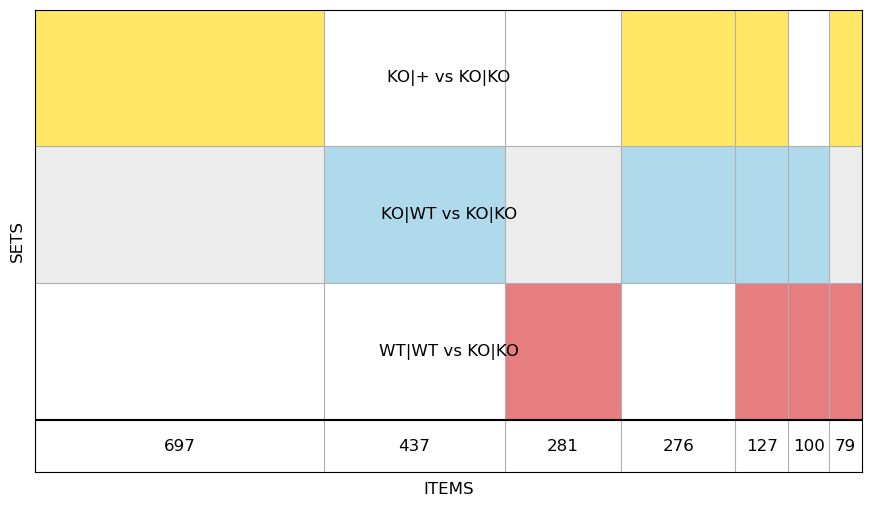

In [10]:
sets = [a, b, c]
labels = ['WT|WT vs KO|KO', 'KO|WT vs KO|KO', 'KO|+ vs KO|KO']
mso = supervenn.supervenn(sets, labels,
                          side_plots=False, chunks_ordering='size', 
                          reverse_sets_order=False, fontsize=12, color_cycle=['tab:red', 'skyblue', 'gold'])

matplotlib.pyplot.show()

In [11]:
print(697+276+127+79)
print(437+276+127+100)
print(281+127+100+79)

1179
940
587


In [12]:
# explore what happened with the effect of restoring 202, independently of the levels. Expect 276 genes
sub = mso.chunks[frozenset([1, 2])]
print(len(sub))

276


In [13]:
df = pandas.DataFrame(sub, columns=['ENSEMBL ID'])
df

,ENSEMBL ID
0,ENSG00000185483
1,ENSG00000169252
2,ENSG00000111802
3,ENSG00000278828
4,ENSG00000113327
...,...
271,ENSG00000228437
272,ENSG00000233237
273,ENSG00000168993
274,ENSG00000241635


In [14]:
annotated = df.join(anno, on='ENSEMBL ID')
annotated.set_index('ENSEMBL ID', inplace=True)
final_df = annotated.rename(columns={'external_gene_name':'Gene name', "gene_biotype":"Gene biotype"})
to_store = final_df[['Gene biotype', 'Gene name', 'Description']]

output_file_name = output_folder + '202isback.tsv'
to_store.to_csv(output_file_name, sep='\t')

to_store

,Gene biotype,Gene name,Description
ENSEMBL ID,,,
ENSG00000185483,protein_coding,ROR1,receptor tyrosine kinase like orphan receptor 1
ENSG00000169252,protein_coding,ADRB2,adrenoceptor beta 2
ENSG00000111802,protein_coding,TDP2,tyrosyl-DNA phosphodiesterase 2
ENSG00000278828,protein_coding,H3C10,H3 clustered histone 10
ENSG00000113327,protein_coding,GABRG2,gamma-aminobutyric acid type A receptor subuni...
...,...,...,...
ENSG00000228437,lncRNA,LINC02474,long intergenic non-protein coding RNA 2474
ENSG00000233237,lncRNA,LINC00472,long intergenic non-protein coding RNA 472
ENSG00000168993,protein_coding,CPLX1,complexin 1


## 202 high dosage response

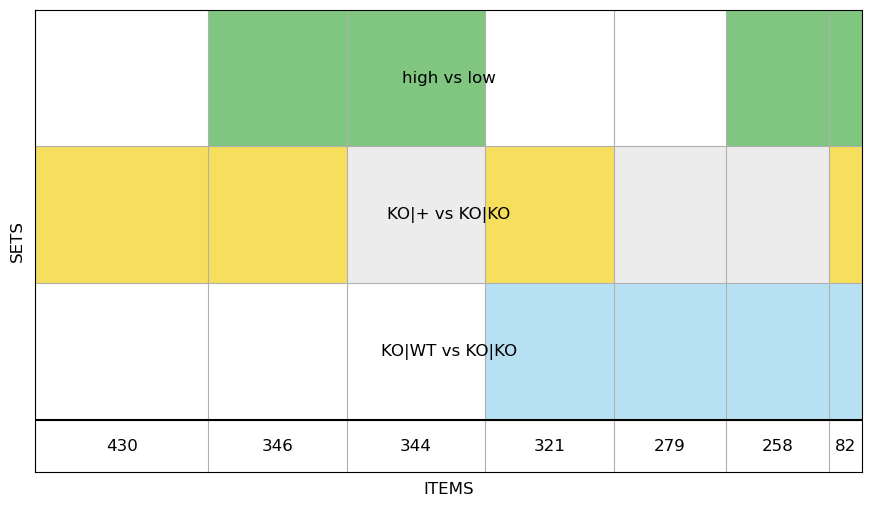

In [15]:
sets = [b, c, d]
labels = ['KO|WT vs KO|KO', 'KO|+ vs KO|KO', 'high vs low']
mso = supervenn.supervenn(sets, labels,
                          side_plots=False, chunks_ordering='size', 
                          reverse_sets_order=False, fontsize=12, color_cycle=['skyblue', 'gold', 'tab:green'])

matplotlib.pyplot.show()

In [16]:
# explore 202 dose response: intersect of high vs KO with high vs low. Expect 346 genes
sub = mso.chunks[frozenset([1, 2])]
print(len(sub))

346


In [17]:
df = pandas.DataFrame(sub, columns=['ENSEMBL ID'])
df

,ENSEMBL ID
0,ENSG00000120738
1,ENSG00000135454
2,ENSG00000130304
3,ENSG00000129295
4,ENSG00000171877
...,...
341,ENSG00000116667
342,ENSG00000107957
343,ENSG00000171310
344,ENSG00000124145


In [18]:
annotated = df.join(anno, on='ENSEMBL ID')
annotated.set_index('ENSEMBL ID', inplace=True)
final_df = annotated.rename(columns={'external_gene_name':'Gene name', "gene_biotype":"Gene biotype"})
to_store = final_df[['Gene biotype', 'Gene name', 'Description']]

output_file_name = output_folder + '202ishigh.tsv'
to_store.to_csv(output_file_name, sep='\t')

to_store

,Gene biotype,Gene name,Description
ENSEMBL ID,,,
ENSG00000120738,protein_coding,EGR1,early growth response 1
ENSG00000135454,protein_coding,B4GALNT1,"beta-1,4-N-acetyl-galactosaminyltransferase 1"
ENSG00000130304,protein_coding,SLC27A1,solute carrier family 27 member 1
ENSG00000129295,protein_coding,DNAAF11,dynein axonemal assembly factor 11
ENSG00000171877,protein_coding,FRMD5,FERM domain containing 5
...,...,...,...
ENSG00000116667,protein_coding,C1orf21,chromosome 1 open reading frame 21
ENSG00000107957,protein_coding,SH3PXD2A,SH3 and PX domains 2A
ENSG00000171310,protein_coding,CHST11,carbohydrate sulfotransferase 11
